In [1]:
from odes.models import SIR
from odes.integrator import integrator
from odes.neural_ODE import nUIV_NODE
import torch
# import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# helper function to step the SIR model forward and generate a data set
def generate_SIR_data(model, num_steps):
    t = torch.zeros(num_steps)
    y = torch.zeros(3, num_steps)
    y[:, 0] = torch.from_numpy(model.x)
    t[0] = torch.tensor(0.0)
    for i in range(num_steps):
        y[:, i] = torch.from_numpy(model.step())
        t[i] = torch.tensor(model.t)
    return y, t


def lp_norm_loss(y, yhat, p=2):
    return torch.norm(y-yhat, p=p)

In [3]:
# setting up SIR reference data
num_hosts = 50
num_steps = 400
dt = 0.05
torch.manual_seed(666)

time_scale = 25.0  # can make time "move faster" by scaling these constants beyond [0, 1]
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.75, 0.25, 0.0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

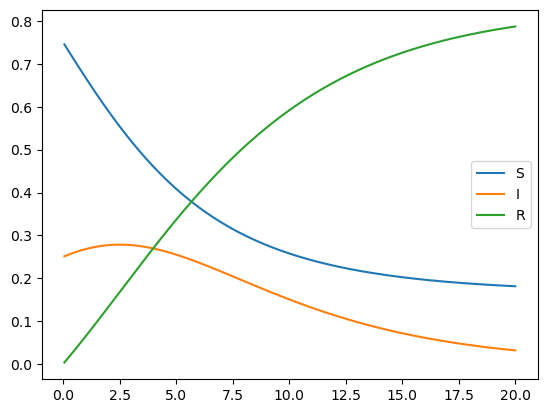

In [4]:
plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [5]:
num_epochs = 200

method = 'euler'
step_size = 2*dt
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nUIV_NODE(num_hosts, method=method, step_size=step_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

loss_function = lambda y, yhat: lp_norm_loss(y, yhat, p=2)  # nn.L1Loss()

y_train = SIR_train_data[1,:]

In [ ]:
model.nUIV_to_SIR.W.weight

In [6]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    y_est = SIR_est[1,:]
    loss = loss_function(y_est, y_train.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')
    # break

g:\UCLA\Research\Epidemiology\epidemiology_sysID\odes\neural_ODE.py:66: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)
  rhs[2::3] += torch.matmul(state[2::3].T, torch.matmul(torch.diag(normalization), self.ts))


Epoch 0, loss value: 5.576578617095947.
Epoch 1, loss value: 2.806461811065674.
Epoch 2, loss value: 3.307865619659424.
Epoch 3, loss value: 3.4319212436676025.
Epoch 4, loss value: 3.474757671356201.
Epoch 5, loss value: 3.4845736026763916.
Epoch 6, loss value: 3.4612889289855957.
Epoch 7, loss value: 3.3816614151000977.
Epoch 8, loss value: 3.2740859985351562.
Epoch 9, loss value: 3.208395481109619.
Epoch 10, loss value: 3.172524929046631.
Epoch 11, loss value: 3.073697805404663.
Epoch 00013: reducing learning rate of group 0 to 5.0000e-02.
Epoch 12, loss value: 2.875847578048706.
Epoch 13, loss value: 2.6000332832336426.
Epoch 14, loss value: 2.3934831619262695.
Epoch 15, loss value: 2.1352059841156006.
Epoch 16, loss value: 1.886362910270691.
Epoch 17, loss value: 1.7763469219207764.
Epoch 18, loss value: 1.6998995542526245.
Epoch 19, loss value: 1.678655743598938.
Epoch 20, loss value: 1.6583160161972046.
Epoch 21, loss value: 1.618510127067566.
Epoch 22, loss value: 1.54365122318

In [7]:
nUIV_params = model.get_params()
SIR_params = {'beta': beta,
              'gamma': gamma,
              'x0': SIR_x0,
              'num_hosts': num_hosts}

sim_params = {'SIR': SIR_params,
              'nUIV': nUIV_params}

print(nUIV_params)

{'beta': array([2.39354461e-01, 9.33850883e-04, 1.07198171e-01, 3.67365932e+00,
       2.25628281e+00, 7.14675011e-03, 1.14076626e+00, 1.91770773e-03,
       5.67519525e-03, 1.80493534e+00, 1.66384742e-01, 5.37389040e-01,
       6.00520940e-03, 1.74591887e+00, 1.29168046e+00, 9.20878010e-05,
       3.77895348e-02, 9.35745761e-02, 8.18761159e-03, 1.05852827e-01,
       1.21967204e-01, 1.01592116e-01, 4.27496321e-02, 8.89566839e-02,
       2.06253350e-01, 6.09727725e-02, 4.85907984e+00, 5.28946407e-02,
       1.00462705e-01, 9.33188260e-01, 2.36749008e-01, 1.61184507e-04,
       4.29117940e-02, 6.62280899e-03, 7.50057027e-03, 7.62589509e-03,
       4.59687831e-03, 2.25228872e-02, 3.09027564e-02, 3.60648218e-03,
       5.72611094e-02, 6.74284995e-01, 3.28903198e+00, 2.63690680e-01,
       5.06206632e-01, 1.18708342e-01, 5.84917784e-01, 4.49468493e-01,
       8.42773318e-02, 4.73200809e-03], dtype=float32), 'delta': array([0.3732923 , 1.761633  , 0.33243865, 0.4520909 , 0.37386304,
       

Resetting to stored initial state.
Resetting to t=0.0.


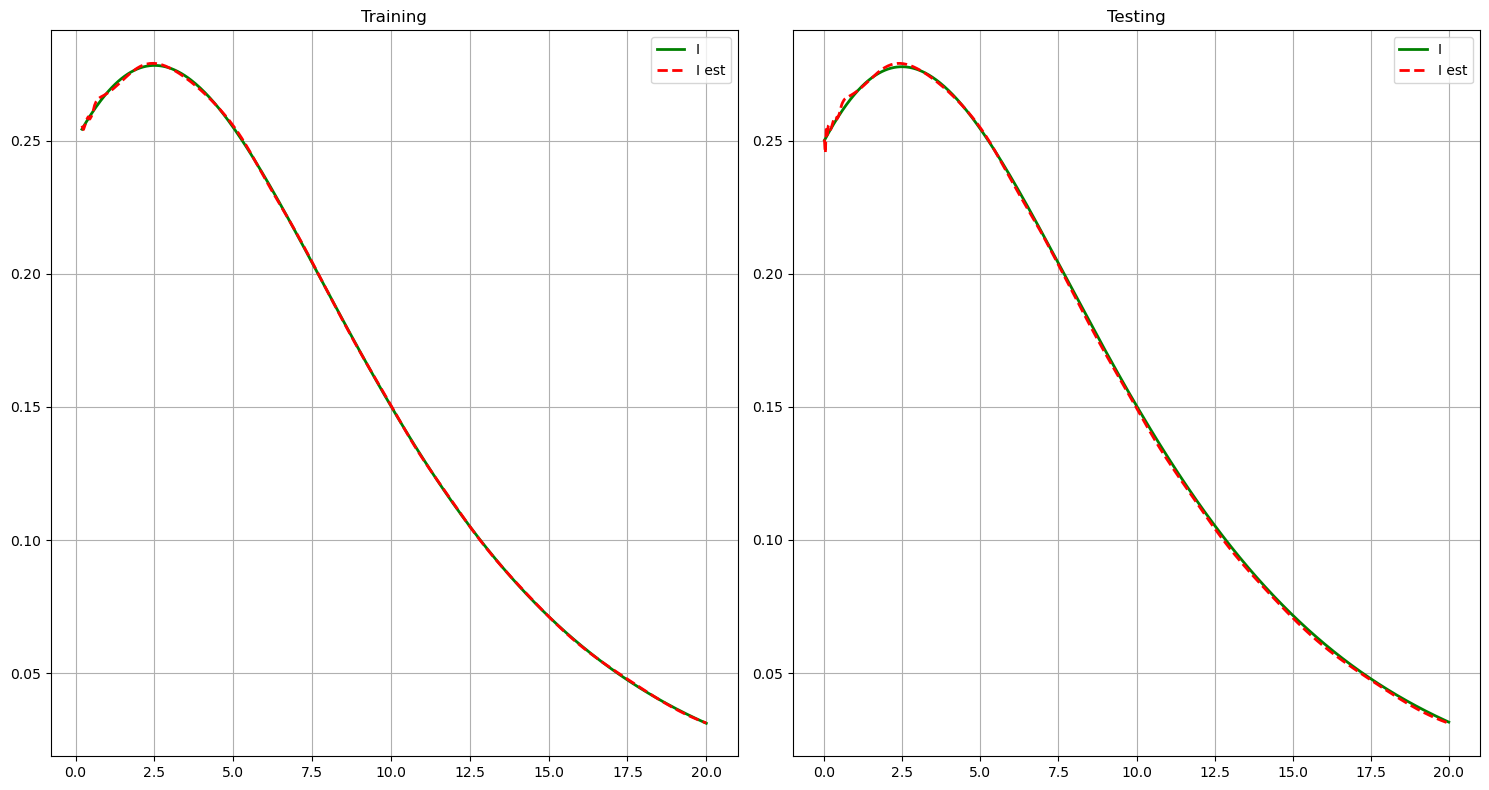

In [8]:
SIR_stepper.reset()
SIR_stepper.dt = 0.001
num_steps = 20000
SIR_test_data, time_test_data = generate_SIR_data(SIR_stepper, num_steps)

with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()
    SIR_test_data_est = model.simulate(time_test_data.to(device)).detach().cpu().numpy()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']
'''
for i, name in enumerate(names):
    ax1.plot(time_train_data, SIR_train_data[i, :], lw=2, color=colors[i], label=name)
    ax1.plot(time_train_data, SIR_train_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
    ax2.plot(time_test_data, SIR_test_data[i, :], lw=2, color=colors[i], label=name)
    ax2.plot(time_test_data, SIR_test_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
'''

ax1.plot(time_train_data[3:], SIR_train_data[1, 3:], lw=2, color=colors[1], label=names[1])
ax1.plot(time_train_data[3:], SIR_train_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax2.plot(time_test_data[3:], SIR_test_data[1, 3:], lw=2, color=colors[1], label=names[1])
ax2.plot(time_test_data[3:], SIR_test_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax1.set_title('Training')
ax2.set_title('Testing')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
f.tight_layout()

path = './tmp/'
if not os.path.exists(path):
    os.mkdir(path)
filename = os.path.join(path, 'last_run_pytorch.png')
f.savefig(filename)
plt.show()

In [11]:
model.nUIV_to_SIR.W.weight

Parameter containing:
tensor([[ 0.0068,  0.4026, -0.5508],
        [ 0.4266, -0.0220,  0.2228],
        [-0.5294,  0.0567, -0.3501]], requires_grad=True)